# Gradient-based Optimization

While there are so-called zeroth-order methods which can optimize a function without the gradient,
most applications use first-order method which require the gradient. We will also show an example
of a second-order method, Newton's method, which require the Hessian matrix (that is, second derivatives).

In our examples, we will optimize the following function of the vector $x$ with two components:

$$
f(x) = -\sin\left(\frac{x_1^2}{2} - \frac{x_2^2}{4} + 3 \right) \cos\left(2x_1 + 1 -e^{x_2}\right)
$$

Since $f$ only depends on two degrees of freedom, we can easily visualize it in the plane.
Below we define the function in Julia, and create a helper function to plot a 2D function using contours.

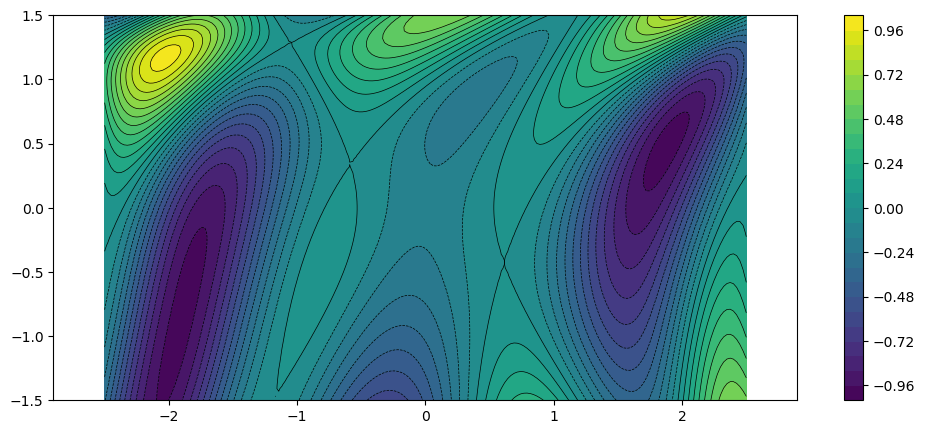

In [2]:
using PyPlot

f(x) = -sin(x[1]^2/2 - x[2]^2/4 + 3) * cos(2x[1] + 1 - exp(x[2]))

function fplot(f)
    x = range(-2.5, stop=2.5, length=200)
    y = range( -1.5, stop=1.5, length=100)
    u = [f([x,y]) for y in y, x in x]
    
    gcf().set_size_inches(12,5)
    contour(x, y, u, 25, colors="k", linewidths=0.5)
    contourf(x, y, u, 25)
    axis("equal")
    colorbar()
    return
end

fplot(f)

Note that although the function is only two-dimensional, it is fairly complex with strong nonlinearities and multiple local extrema.

## Gradient function

Since our methods will be gradient based, we also need to differentiate $f(x)$
to produce the gradient $\nabla f(x)$. Since this can be difficult to obtain,
or at least highly time consuming, later we will explore alternatives to this
such as numerical differentiation and automatic (symbolic) differentiation.
But to begin with it is convenient to have a function for the gradient, which we
define below.

In [3]:
function df(x)
    a1 = x[1]^2/2 - x[2]^2/4 + 3
    a2 = 2x[1] + 1 - exp(x[2])
    b1 = cos(a1)*cos(a2)
    b2 = sin(a1)*sin(a2)
    return -[x[1]*b1 - 2b2, -x[2]/2*b1 + exp(x[2])*b2]
end

df (generic function with 1 method)

## Gradient descent

The *gradient descent method*, or *steepest descent*, is based on the observation that for any
given value of $x$, the negative gradient $-\nabla f(x)$ gives the direction of the fastest
decrease of $f(x)$. This means that there should be a scalar $\alpha$ such that

$$
f(x - \alpha\nabla f(x)) < f(x)
$$

Assuming such an $\alpha$ can be found, the method then simply starts at some *initial guess* $x_0$
and iterates

$$
x_{k+1} = x_k - \alpha_k \nabla f(x_k)
$$

until some appropriate termination criterion is satisfied. With some assumptions, the method can be
shown to converge to a local minimum.

In our first implementation below, we simply set $\alpha_k$ to a specified constant.
We also use $\|\nabla f(x)\|_2$ for the termination criterion (which goes to zero at local minima).
In order to study the methods properties, we output all of the steps $x_k$ in a vector.

In [4]:
function gradient_descent(f, df, x0, α=0.1; tol=1e-4, maxiter=500)
    x = x0
    xs = [x0]
    for i = 1:maxiter
        gradient = df(x)
        if sqrt(sum(gradient.^2)) < tol
            break
        end
        x -= α*gradient
        push!(xs, x)
    end
    return xs
end

gradient_descent (generic function with 2 methods)

We can now run the method on our test problem. We first define a helper function to plot the
"path" of the gradient descent method:

In [5]:
function plot_path(xs)
    plot(first.(xs), last.(xs), "w.", markersize=6)
    plot(first.(xs), last.(xs), "r", linewidth=1)
end

plot_path (generic function with 1 method)

Next we define three initial guesses $x_0$, which are close to different local minima:

In [6]:
x0s = [[-2,.5], [0,.5], [2.2,-0.5]];

Finally we run the code for each $x_0$ and plot the paths. We also output the
length of the paths, and the gradient norm at the final iteration.

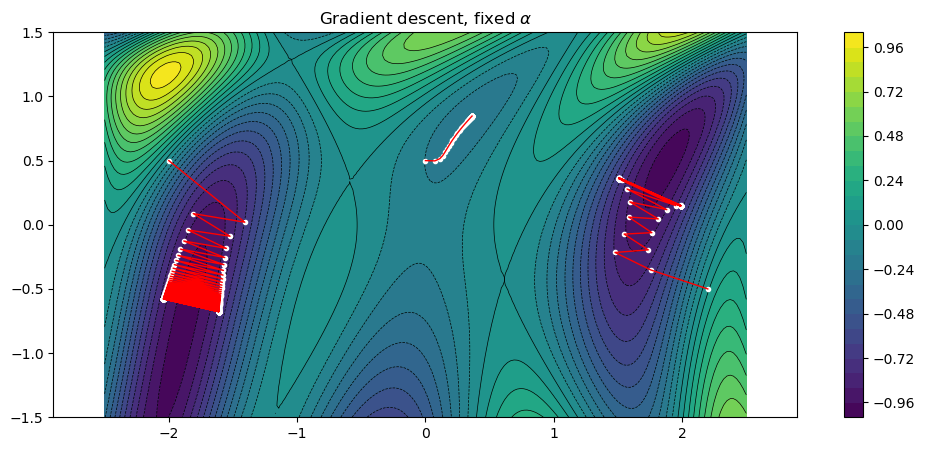

Path length = 501, ||gradient|| = 1.4715843307921153
Path length = 67, ||gradient|| = 8.918594790414185e-5
Path length = 501, ||gradient|| = 1.7575802156689122


In [7]:
fplot(f)
title("Gradient descent, fixed \$\\alpha\$")
for x0 in x0s
    xs = gradient_descent(f, df, x0, 0.3)
    plot_path(xs)
    println("Path length = $(length(xs)), ||gradient|| = $(sqrt(sum(df(xs[end]).^2)))")
end

We note that the method can indeed find minima, but suffers from a few problems:

* The selection of $\alpha$ is manual and non-obvious. If it is too large, the iterations might
  end up too far from the minimum. If it is too small, a large number of iterations are needed.
  We will solve this below by introducing so-called *line searches*.
  
* The method "zig-zags", in particular if $\alpha$ is too large. This is a fundamental problem
  with the gradient descent method, and the reason that we will look at better search directions
  (such as Newton's method).

### Line searches

One way to improve the gradient descent method is to use a *line search* to determine
$\alpha_k$. The idea is simple: instead of using a fixed $\alpha_k$, we minimize
the one-dimensional function $f(\alpha) = f(x_k - \alpha\nabla f(x_k))$. This can be
done in many ways, but here we use a simple strategy of successively increasing $\alpha$
(by factors of $2$) as long as $f$ decreases.

In [8]:
function line_search(f, direction, x, αmin=1/2^20, αmax=2^20)
    α = αmin
    fold = f(x)
    while true
        if α ≥ αmax
            return α
        end
        fnew = f(x - α*direction)
        if fnew ≥ fold
            return α/2
        else
            fold = fnew
        end
        α *= 2
    end
end

line_search (generic function with 3 methods)

Next we write a new gradient descent method which uses line searches instead of
fixed $\alpha_k$. It is a very minor change to the previous function and we could
easily have written one general function to handle both these cases, but for
simplicity we create a new function.

In [9]:
function gradient_descent_line_search(f, df, x0; tol=1e-4, maxiter=500)
    x = x0
    xs = [x0]
    for i = 1:maxiter
        gradient = df(x)
        if sqrt(sum(gradient.^2)) < tol
            break
        end
        α = line_search(f, gradient, x)
        x -= α*gradient
        push!(xs, x)
    end
    return xs
end

gradient_descent_line_search (generic function with 1 method)

Running the same test case as before with this function, we see that it automatically
determines appropriate $\alpha_k$ values and converge for all three initial guesses.

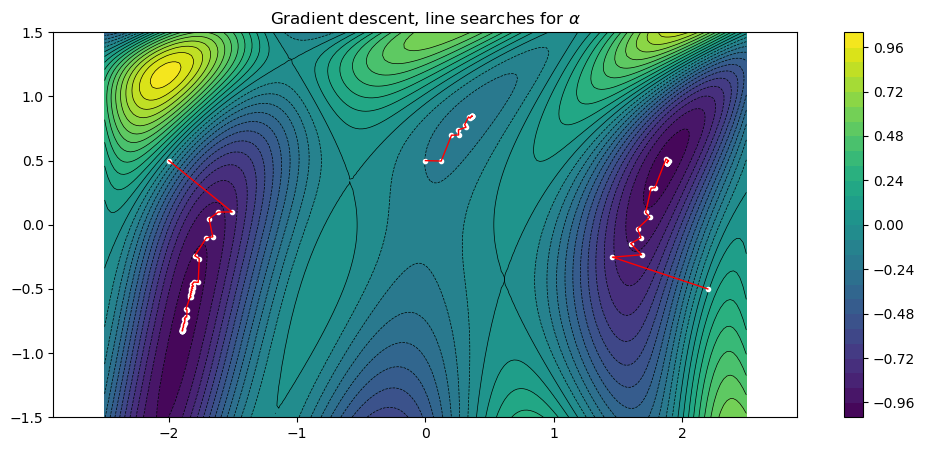

Path length = 47, ||gradient|| = 7.870693264979224e-5
Path length = 19, ||gradient|| = 2.7076595197863102e-5
Path length = 34, ||gradient|| = 6.99663461959244e-5


In [10]:
fplot(f)
title("Gradient descent, line searches for \$\\alpha\$")
for x0 in x0s
    xs = gradient_descent_line_search(f, df, x0)
    plot_path(xs)
    println("Path length = $(length(xs)), ||gradient|| = $(sqrt(sum(df(xs[end]).^2)))")
end

### Numerical gradients

An alternative to implementing the gradient function `df` by hand as above, it can
be computed numerically using finite differences:

$$
\left(\nabla f(x)\right)_k \approx \frac{f(x + \epsilon d^k) - f(x - \epsilon d^k)}{2\epsilon}
$$

Here, $\epsilon$ is a (small) step size parameter, and the vector $d^k$ is defined by $(d^k)_j = \delta_{ij}$
(that is, a zero vector with a single 1 at position $k$).

In [11]:
function finite_difference_gradient(f, x, ϵ=1e-5)
    n = length(x)
    df = zeros(n)
    for k = 1:n
        x1 = copy(x)
        x1[k] += ϵ
        fP = f(x1)
        x1[k] -= 2ϵ
        fM = f(x1)
        df[k] = (fP - fM) / 2ϵ
    end
    return df
end

finite_difference_gradient (generic function with 2 methods)

We can now run the previous test case, without having to compute `df`:

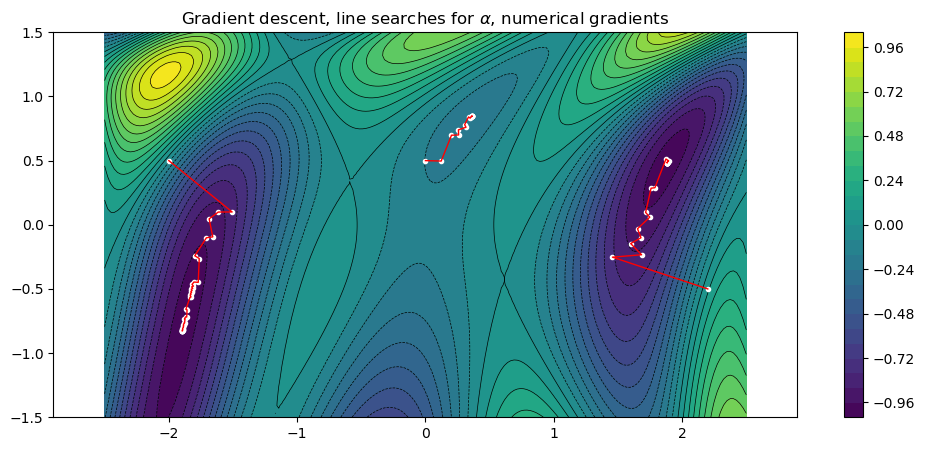

Path length = 47, ||gradient|| = 7.870696304745967e-5
Path length = 19, ||gradient|| = 2.7076778424462065e-5
Path length = 34, ||gradient|| = 6.996618216493087e-5


In [12]:
fplot(f)
title("Gradient descent, line searches for \$\\alpha\$, numerical gradients")
for x0 in x0s
    num_df(x) = finite_difference_gradient(f, x)
    xs = gradient_descent_line_search(f, num_df, x0)
    plot_path(xs)
    println("Path length = $(length(xs)), ||gradient|| = $(sqrt(sum(df(xs[end]).^2)))")
end

## Newton's method

Even with line searches, the gradient descent method still suffers from the zig-zag behavior
and slow convergence. If second derivatives can be obtained, *Newton's method* can converge
much faster. A simple way to describe the method is that we change the search direction in
gradient descent to $H(x_k)^{-1}\nabla f(x_k)$ instead of just $\nabla f(x_k)$, where
$H(x_k)$ is the *Hessian matrix*.

We compute $H(x)$ numerically using similar expressions as before (but for second derivatives):

In [13]:
function finite_difference_hessian(f, x, ϵ=1e-5)
    n = length(x)
    ddf = zeros(n,n)
    f0 = f(x)
    for i = 1:n
        x1 = copy(x)
        x1[i] += ϵ
        fP = f(x1)
        x1[i] -= 2ϵ
        fM = f(x1)
        ddf[i,i] = (fP - 2*f0 + fM) / ϵ^2
    end
    for i = 1:n, j = i+1:n
        x1 = copy(x)
        x1[i] += ϵ
        x1[j] += ϵ
        fPP = f(x1)
        x1[i] -= 2ϵ
        fMP = f(x1)
        x1[j] -= 2ϵ
        fMM = f(x1)
        x1[i] += 2ϵ
        fPM = f(x1)
        ddf[i,j] = (fPP - fMP - fPM + fMM) / 4ϵ^2
        ddf[j,i] = ddf[i,j]
    end
    return ddf
end

finite_difference_hessian (generic function with 2 methods)

We implement Newton's method by re-using our gradient descent method with a different gradient direction.

Newton's method is more sensitive to the initial guess $x_0$, and in order to converge we have to move
two of our values closer to their minima. However, when the method converges it is very fast.

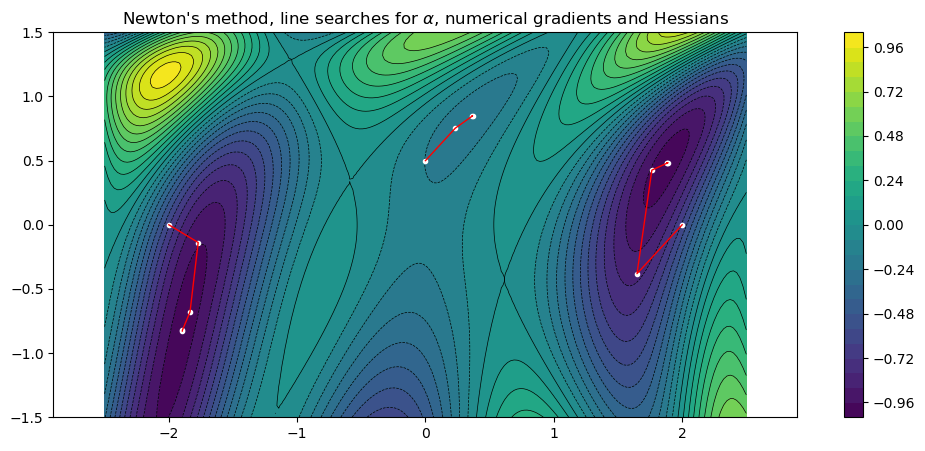

Path length = 5, ||gradient|| = 2.459525335329783e-6
Path length = 4, ||gradient|| = 1.2237414654119817e-5
Path length = 6, ||gradient|| = 1.7631665079368057e-8


In [14]:
fplot(f)
title("Newton's method, line searches for \$\\alpha\$, numerical gradients and Hessians")
x0s = [[-2,0.0], [0,.5], [2.,0.]];
for x0 in x0s
    search_dir(x) = finite_difference_hessian(f,x) \ finite_difference_gradient(f, x)
    xs = gradient_descent_line_search(f, search_dir, x0)
    plot_path(xs)
    println("Path length = $(length(xs)), ||gradient|| = $(sqrt(sum(df(xs[end]).^2)))")
end